In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np    
import ROOT
import root_numpy as rtnp

import cygnus_lib as cy
import mylib as my
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from itertools import combinations
import math
import os

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

Welcome to JupyROOT 6.22/06


In [2]:
def ped_(run, path='./', tag = 'LAB', min_image_to_read = 0, max_image_to_read = 0):
    #
    # run numero del run
    # path path lettura/scrittura piedistalli
    # tag subdirectory dei dati
    # min_image_to_read , max_image_to_read  range di imagine sul quale fare i piedistalli 
    # max_image_to_read = 0 EQUIVALE A TUTTE LE IMMAGINI
    #
    import ROOT
    import root_numpy as rtnp
    import numpy as np
    import cygnus_lib as cy
    # funzione per fare i piedistalli se gia' non esistino nella diretory
    fileoutm = (path+"run%d_mean.h5" % (run))
    fileouts = (path+"run%d_sigma.h5" % (run))
    try: 
        # i file gia' esistono
        m_image = cy.read_image_h5(fileoutm)
        s_image = cy.read_image_h5(fileouts)
        return m_image, s_image
    except:
        # i file non esistono crea il file delle medie e delle sigma per ogni pixel dell'immagine
        print (">>> Pedestal Maker! <<<")
        try:
            
            print ('Open file: '+cy.swift_root_file(tag, run))
            f=ROOT.TFile.Open(cy.swift_root_file(tag, run))
            print ('Find Keys: '+str(len(f.GetListOfKeys())))
            pic, wfm = cy.root_TH2_name(f)
            max_image = len(pic)
            max_wfm = len(wfm)
            image = rtnp.hist2array(f.Get(pic[0])).T
            x_resolution = image.shape[1]
            y_resolution = image.shape[0]
            print ("# of Images (TH2) Files: %d " % (max_image))
            print ("# of Waveform (TH2) Files: %d " % (max_wfm))

        except:
            print ("ERROR: No file %d" % (run))
            return
        if max_image_to_read == 0:
            max_image_to_read=max_image 
        print ("WARNING: pdestal from %d to %d" % (min_image_to_read, max_image_to_read))

        m_image = np.zeros((x_resolution, y_resolution), dtype=np.float64)
        s_image = np.zeros((x_resolution, y_resolution), dtype=np.float64)

        n0 = 0
        for iTr in range(min_image_to_read, max_image_to_read):
            image = rtnp.hist2array(f.Get(pic[iTr])).T
            m_image += image
            s_image += image**2 
            if n0 > 0 and n0 % 10==0:  # print progress and debung info for poit 200, 200...
                print ("Debug Image[200,200]: %d => %.2f %.2f %.2f " % (iTr,
                                                image[200,200],
                                                np.sqrt((s_image[200,200] - 
                                                        m_image[200,200]**2 
                                                          / (n0+1)) / n0),
                                                m_image[200,200]/(n0+1),
                                                ))
            n0 += 1
        m_image = m_image/n0
        s_image = np.sqrt((s_image - m_image**2 * n0) / (n0 - 1))

        ###### print Info and Save OutPut ######################################

        print ("sigma %f" % (s_image[200,200]))
        cy.write_image_h5(fileoutm, m_image)
        cy.write_image_h5(fileouts, s_image)
        print("DONE OUTPUT on files: %s, %s", (fileoutm, fileouts))
        return m_image, s_image

/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


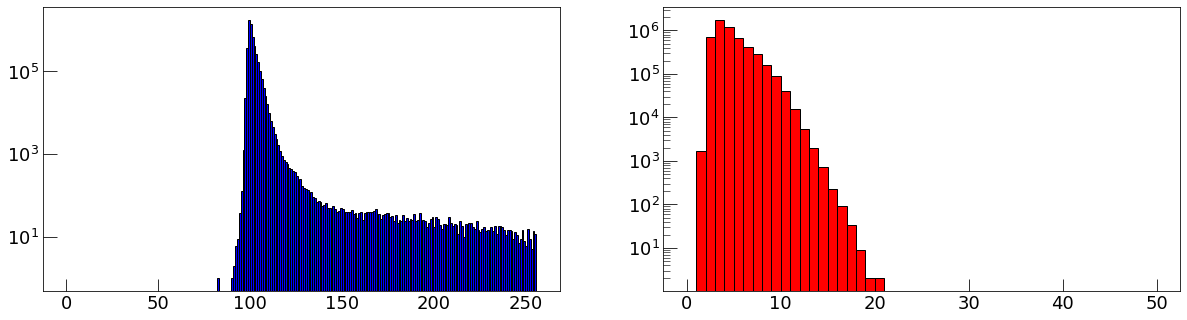

In [3]:
m_image, s_image = ped_(4026)
cy.set_atlas_style('long')
fig, ax = plt.subplots(1,2)
ax[0].hist(m_image.ravel(), bins=256, range=(0.0, 256.0), fc='b', ec='k')
ax[1].hist(s_image.ravel(), bins=50, range=(0.0, 50.0), fc='r', ec='k')
ax[0].set_yscale("log")
ax[1].set_yscale("log")
plt.show()

In [155]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse_par(x, y):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)

    if np.sqrt(cov[0, 0] * cov[1, 1]) == 0:
        width = height = -1
        pearson = np.nan
    else:
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        # Using a special case to obtain the eigenvalues of this
        # two-dimensionl dataset.

        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        width=ell_radius_x * 2
        height=ell_radius_y * 2
    return width, height, pearson

def cluster_par(xc, yc, image):
    ph = 0.
    dim = xc.shape[0]
    for j in range(0, dim):
        x = int(xc[j])
        y = int(yc[j])
        ph += (image[y,x])
    return ph, dim

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)



    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    #print (ellipse, transf)
    return ax.add_patch(ellipse), ellipse


def cluster_elips(points):
    x0i= np.argmin(points[:,1])
    a0 = points[x0i][1]
    x1i= np.argmax(points[:,1])
    a1 = points[x1i][1]
    y0i= np.argmin(points[:,0])
    b0 = points[y0i][0]
    y1i= np.argmax(points[:,0])
    b1 = points[y1i][0]
    #print (a0, a1, b0, b1, x0i, points[x0i])
    a  = (a1 - a0)/2.
    b  = (b1 - b0)/2.
    x0 = (a1 + a0)/2.
    y0 = (b1 + b0)/2.
    theta = np.arctan((points[x1i][0]-points[x0i][0])/(points[x1i][1]-points[x0i][1]))
    return x0, y0, a , b, theta


def poit_3d(points, image):
    ########### if 3D #############
    points_3d = []
    for j in range(len(points)):
        x = points[j,0]
        y = points[j,1]
        z = image[int(y),int(x)]
        points_3d.append([y,x,z]) 

    return points_3d
    # #######################


In [10]:
run = 4020
tag = "LAB" # Run tag: MAN, FNG, LAB, BTF, LTD
bpath = '/workarea/cloud-storage/cygnus/Data/'
path = bpath+tag+'/histograms_Run{:05d}'.format(run)+'.root'

print ('Open file: '+path)
f = ROOT.TFile.Open(path)

print ('Find Keys: '+str(len(f.GetListOfKeys())))
pic, wfm = cy.root_TH2_name(f)
max_image = len(pic)
max_wfm = len(wfm)
print ("# of Images (TH2) Files: {:d}".format(max_image))
print ("# of Waveform (TH2) Files: {:d} ".format(max_wfm))

image = rtnp.hist2array(f.Get(pic[0])).T
x_resolution = image.shape[1]
y_resolution = image.shape[0]
print ('Camera X, Y pixel: {:d} {:d} '.format(x_resolution, y_resolution))

Open file: /workarea/cloud-storage/cygnus/Data/LAB/histograms_Run04020.root
Find Keys: 100
# of Images (TH2) Files: 100
# of Waveform (TH2) Files: 0 
Camera X, Y pixel: 2304 2304 


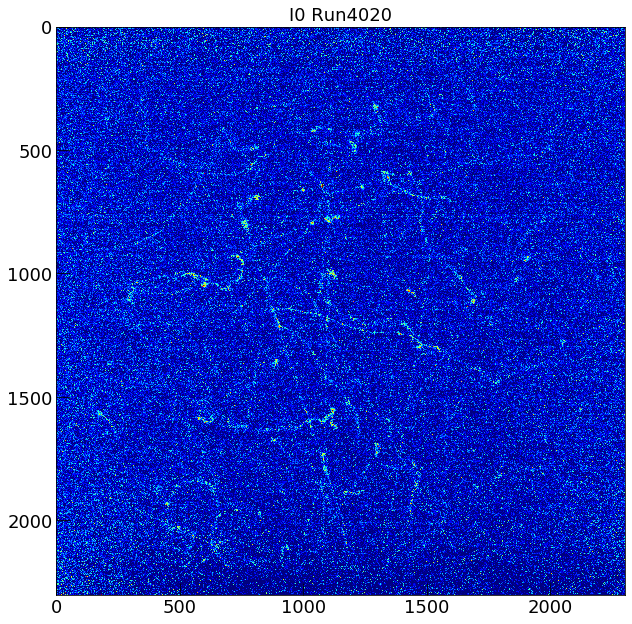

In [12]:
iTr = 0 # numero imagine da leggere
save = False
image = rtnp.hist2array(f.Get(pic[iTr])).T
fig = plt.figure(figsize=(10,10))
plt.title("I%d Run%d" % (iTr, int(run)))
plt.imshow(image-m_image,  cmap="jet", vmin=-5,vmax=50)
plt.show()

In [197]:
runI          = [4020] 
run_ped       = 4026
#run_ped       = 4020
cimax         = 10
cimin         = 0 
tag           = 'LAB'
rescale       = 576
nsigma        = 1.0


#########################

m_image, s_image = ped_(run_ped)

#########################

th_image   = np.round(m_image + nsigma*s_image)
print ("light over Th: %.2f " % (th_image.sum()-m_image.sum()))
    
for nRi in range(len(runI)):
    try:
        print ('Open file: '+cy.swift_root_file(tag, runI[nRi]))
        f = ROOT.TFile.Open(cy.swift_root_file(tag, runI[nRi]))
        print ('Find Keys: '+str(len(f.GetListOfKeys())))
        pic, wfm = cy.root_TH2_name(f)
        max_image = len(pic)
        max_wfm = len(wfm)
        print ("# of Images (TH2) Files: %d " % (max_image))
        print ("# of Waveform (TH2) Files: %d " % (max_wfm))

    except:
        print ("ERROR: No file %d" % (runI[nRi]))
        break
    # crea un db vuoto da riempire 
    df = pd.DataFrame(columns = ["iTr", "cluster_lable", "pixels", "photons", "ph_pixels", "x0start", "y0start", 
          "x0end", "y0end", "width", "height", "pearson"])
    # crea nome file di output
    file_out = ("dbscan_run%d_cmin_%d_cmax_%d_rescale_%d_nsigma_%.1f_ev_%d_ped_%d.plk.gz" % 
                (runI[nRi], cimin, cimax, rescale, nsigma, max_image, run_ped))
    for iTr in range(0, 1): # max_image per tutte le imagini
        if iTr % 10 == 0: 
          # running & debug ...
          print ('Processing RUN: ', runI[nRi], 'Event: ', iTr)
          # end 

    image = rtnp.hist2array(f.Get(pic[iTr])).T

    rebin_image     = cy.rebin(image-m_image, (rescale, rescale))  
    rebin_th_image  = cy.rebin((th_image-m_image), (rescale, rescale))

    edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax)         
    points          = np.array(np.nonzero(edges)).T.astype(float) 
    # X_scaled        = StandardScaler().fit_transform(points) # 2D
    X_scaled        = StandardScaler().fit_transform(poit_3d(points, rebin_image)) # 3D
    dbscan   = DBSCAN(eps=0.08, min_samples = 5).fit(points) # eps=0.08 per 3D 0.04 2D
    clusters = dbscan.fit_predict(X_scaled)
    n_cluster = max(dbscan.labels_)
    print (n_cluster) 
    for ic in range(0, n_cluster):
        ph = 0.
        yc = points[:,1][dbscan.labels_==ic]
        xc = points[:,0][dbscan.labels_==ic]
        ph, dim = cy.cluster_par(yc, xc, rebin_image)
        width, height, pearson = cy.confidence_ellipse_par(yc,xc)
        for j in range(0, dim):
            x=int(xc[j])
            y=int(yc[j])
            #ph += rebin_image[y,x]
            if j == 0:
                x0start = x
                y0start = y
        x0end = x
        y0end = y
        # print(iTr, ic, dim, ph, ph/dim,x0start,y0start,x0end, y0end, width, height,pearson)
        df = df.append({"iTr":iTr, "cluster_lable":ic, "pixels":dim, "photons":ph, "ph_pixels":ph/dim, "x0start":x0start, "y0start":y0start, 
          "x0end":x0end, "y0end":y0end, "width":width, "height":height, "pearson":pearson},
                       ignore_index=True)
    df.to_pickle(file_out, compression='gzip')
    print ("out file", file_out)

light over Th: nan 
Open file: https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/LAB/histograms_Run04020.root
Find Keys: 100
# of Images (TH2) Files: 100 
# of Waveform (TH2) Files: 0 
Processing RUN:  4020 Event:  0


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


122
out file dbscan_run4020_cmin_0_cmax_10_rescale_576_nsigma_1.0_ev_100_ped_4026.plk.gz


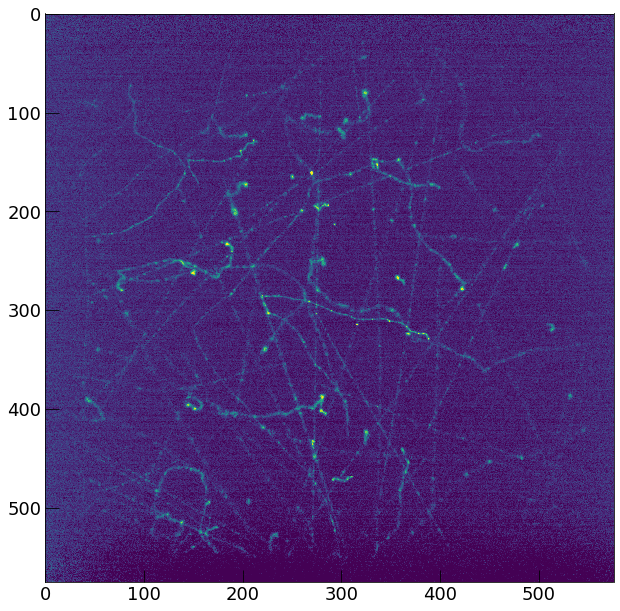

122


In [198]:
fig = plt.figure(figsize=(10,10))
plt.imshow(rebin_image, vmin=-5, vmax=30)
#plt.plot(edges[:,1],edges[:,0], 'r.', markersize=1)
#plt.imshow(edges, vmin=0, vmax=1)
#plt.scatter(points[:,1], points[:,0], s=3, c=dbscan.labels_, cmap="plasma")
# n_cluster = max(dbscan.labels_)
# ic = 2
# yc = points[:,1][dbscan.labels_==ic]
# xc = points[:,0][dbscan.labels_==ic]
# plt.plot(yc,xc, 'r.', markersize=1)
plt.show()
print(n_cluster)

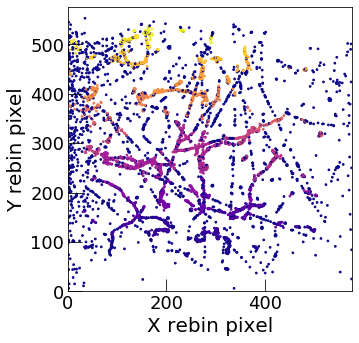

122 30.5 31 4


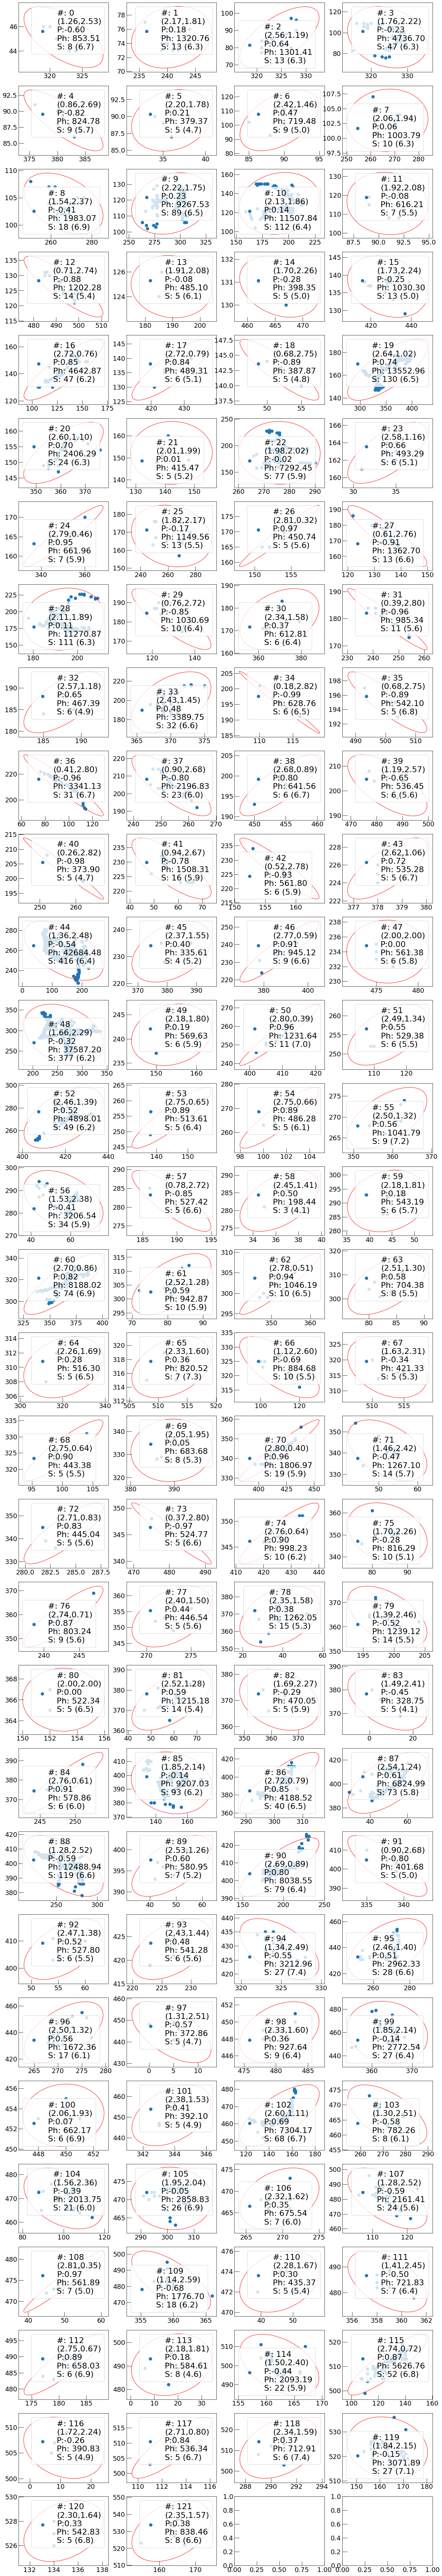

In [199]:
from matplotlib import patches
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
#####################################################
xyscale = x_resolution/rescale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(poit_3d(points, rebin_image))
#X_scaled = scaler.fit_transform(points)

dbscan = DBSCAN(eps=0.08, min_samples = 5) # eps=0.1
# dbscan.fit(points)
dbscan.fit(X_scaled)


clusters = dbscan.fit_predict(X_scaled)
fig = plt.subplots(figsize=(5,5))
plt.scatter(points[:,1], points[:,0], s=3, c=dbscan.labels_, cmap="plasma")
plt.xlabel("X rebin pixel")
plt.ylabel("Y rebin pixel")
plt.xlim(0,rebin_image.shape[0])
plt.ylim(0,rebin_image.shape[1])
plt.show()

for i in range (min(dbscan.labels_), max(dbscan.labels_)):
    ph = 0
    for j in range(0, len(points[:,1][dbscan.labels_==i])):
        ph += (rebin_image[int(points[j,1]), int(points[j,0])])
    #print(i,np.sum([dbscan.labels_==i]), ph, ph/np.sum([dbscan.labels_==i]))

n_cluster = max(dbscan.labels_)
h_plot = 4
l_plot    = math.ceil(n_cluster/h_plot)

print (n_cluster,n_cluster/h_plot, l_plot, h_plot) 
fig, ax = plt.subplots(l_plot, h_plot, figsize=(20, l_plot*4))
h_plot_i    = 0
l_plot_i    = 0
for ic in range(0, n_cluster):
    el_plt, el_par = confidence_ellipse(points[:,1][dbscan.labels_==ic], points[:,0][dbscan.labels_==ic], 
                                        ax[l_plot_i, h_plot_i], edgecolor='red')
    ph, dim = cluster_par(points[:,1][dbscan.labels_==ic], points[:,0][dbscan.labels_==ic], rebin_image)
    width, height, pearson = confidence_ellipse_par(points[:,1][dbscan.labels_==ic], 
                                                    points[:,0][dbscan.labels_==ic])
    ax[l_plot_i, h_plot_i].scatter(points[:,1][dbscan.labels_==ic], points[:,0][dbscan.labels_==ic], 
                                   label = ('#: %d\n(%.2f,%.2f)\nP:%.2f\nPh: %.2f\nS: %d (%.1f)' %
                                            (ic, width, height, pearson, ph*xyscale*xyscale, dim, ph/dim)))

    ax[l_plot_i, h_plot_i].legend()
    if (h_plot_i==h_plot-1):
        h_plot_i = 0
        l_plot_i +=1
    else:
        h_plot_i +=1
plt.show()

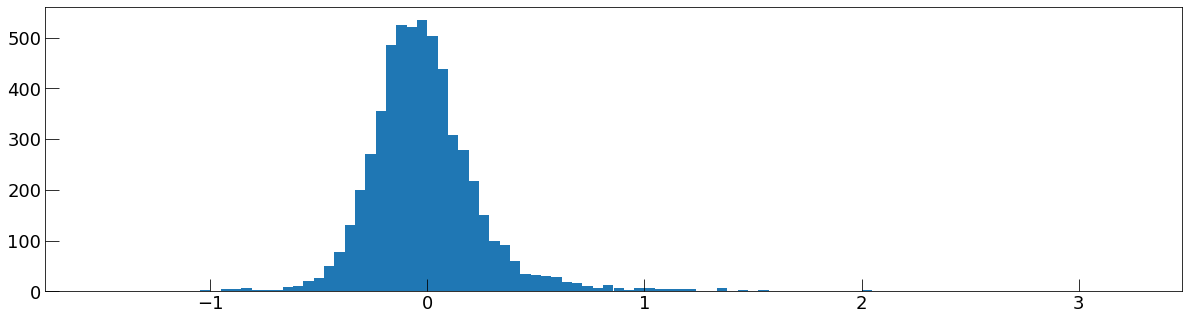

In [165]:
plt.hist(X_scaled[:,2][X_scaled[:,2]<10], bins=100)
#plt.yscale('log')
plt.show()

In [196]:
m_image

array([[103.88, 107.04, 102.42, ..., 102.2 , 105.75, 102.41],
       [106.53, 103.14, 103.53, ..., 104.47, 102.16, 108.75],
       [103.96, 111.99, 104.47, ..., 103.03, 103.47, 107.48],
       ...,
       [103.9 , 103.32, 105.77, ..., 107.38, 105.63, 104.77],
       [105.09, 103.85, 105.39, ..., 112.79, 105.45, 105.51],
       [113.93, 103.32, 108.02, ..., 104.43, 107.82, 105.97]])

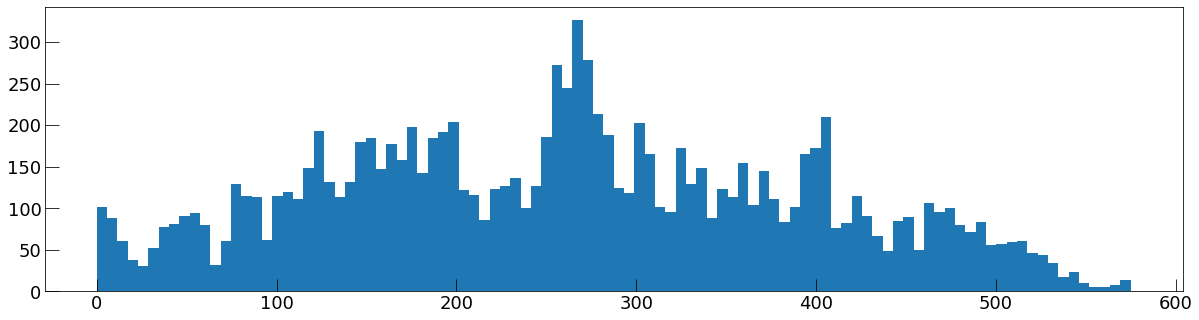

In [139]:
plt.hist(points.ravel(), bins=100)
plt.show()